In [78]:
import pandas as pd
import sklearn 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn import feature_selection
import seaborn as sns
import scipy.stats
from matplotlib import pyplot as plt
import math
import openpyxl
from  matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import xlsxwriter
from sklearn import feature_selection
from scipy.stats import t

In [11]:
#Fundo a ser analisado
nome_da_base = 'bookx'#'book_pagaya_riverview'
col_fundos_input = ['JPEIGLSP Index','BRL Curncy','CAD Curncy','AUD Curncy']#['Pagaya Opportunity Fund','Riverview ALF']
nome_benchmark = 'DXY Index'#"IBOXHY Index"
diaria=0
tempo = 12 #252
const = 0.03
df=pd.read_csv('P:\\ciencia_de_dados\\Correlacao_de_fundos\\Desenvolvimento\\1DataPrep\\base_'+ nome_da_base + '.csv',sep =';',index_col=0,decimal=',')

if diaria==1:
    df_diaria = pd.read_csv('P:\\ciencia_de_dados\\Correlacao_de_fundos\\Desenvolvimento\\1DataPrep\\base_'+ nome_benchmark + '.csv',sep =';',index_col=0,decimal=',')
    df = pd.concat([df_diaria, df])

In [12]:
df

,index,Product,MesAno,data,FinancialPrice,Mes_nomial,Mes,Ano,Retorno_1,Retorno
677,677,JPEIGLSP Index,10-2021,2021-10-20,333.0000,Oct,10,2021,NaN,NaN
665,665,JPEIGLSP Index,09-2021,2021-09-30,324.3700,Sep,9,2021,1.026606,0.026605
653,653,JPEIGLSP Index,08-2021,2021-08-31,327.4400,Aug,8,2021,0.990624,-0.009376
641,641,JPEIGLSP Index,07-2021,2021-07-30,331.8300,Jul,7,2021,0.986770,-0.013230
629,629,JPEIGLSP Index,06-2021,2021-06-30,312.5000,Jun,6,2021,1.061856,0.061856
...,...,...,...,...,...,...,...,...,...,...
70,70,AUD Curncy,07-2010,2010-07-30,0.9026,Jul,7,2010,1.017394,0.017394
58,58,AUD Curncy,06-2010,2010-06-30,0.8765,Jun,6,2010,1.029778,0.029778
46,46,AUD Curncy,05-2010,2010-05-31,0.9261,May,5,2010,0.946442,-0.053558
34,34,AUD Curncy,04-2010,2010-04-30,0.9351,Apr,4,2010,0.990375,-0.009625


In [13]:
x1 = 'CAD Curncy'
x2 = 'JPEIGLSP Index'

In [14]:
df_sub = df.pivot(index=["data","Ano","Mes"], columns="Product", values="Retorno_1")
df_sub = df_sub.reset_index()
df_sub = df_sub.dropna()

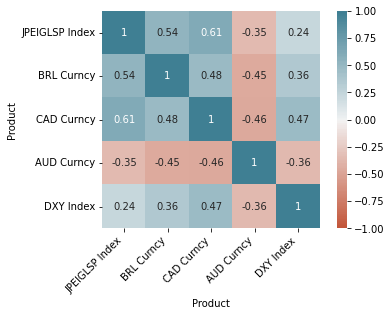

In [15]:
col_fundos1 =col_fundos_input
col_fundos1.append(nome_benchmark)

corr = df_sub[col_fundos_input].corr()

col_fundos1 =col_fundos_input
ax = sns.heatmap(
    corr,
    annot=True, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.savefig('CorrelationMatrix.png',dpi=200)

In [64]:
diff=[]
coef_b=[]
coef_s=[]
coef_out_of_sample=[]

janela_target=12

def func(df,k):
    n1=10
    if k>=30:
        n1=30
    df_rand = df[0:24+k].sample(n = n1)
    return scipy.stats.pearsonr(df_rand[x1], df_rand[x2])[0]
   
for k in range(0,len(df_sub[x1])-(25+janela_target)):
    
    coef_s.append(scipy.stats.pearsonr(df_sub[x1][k:k+24], df_sub[x2][k:k+24])[0])
    coef_out_of_sample.append(scipy.stats.pearsonr(df_sub[x1][k+25:k+25+janela_target], df_sub[x2][k+25:k+25+janela_target])[0])
    coef_b.append(np.mean([func(df_sub,k) for i in range(5000)]))

    
df_teste = pd.DataFrame(
    {'Correlacao_futura_out_of_sample': coef_out_of_sample,
     'Correlacao_BoostStrapping': coef_b,
     'Correlacao_simples_24_meses': coef_s
    })
df_teste['Correlacao_BoostStrapping_erro'] = df_teste.Correlacao_futura_out_of_sample - df_teste.Correlacao_BoostStrapping
df_teste['Correlacao_Simples_24_meses_erro'] = df_teste.Correlacao_futura_out_of_sample - df_teste.Correlacao_simples_24_meses

In [83]:
df_teste.to_excel('teste_correlacao.xlsx')

In [66]:
sum((df_teste.Correlacao_BoostStrapping_erro)**2) / len(df_teste.Correlacao_BoostStrapping_erro)


0.06051539054326179

In [67]:
sum((df_teste.Correlacao_Simples_24_meses_erro)**2) / len(df_teste.Correlacao_BoostStrapping_erro)

0.11812123306115857

c:\users\carol\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.4944483143404834

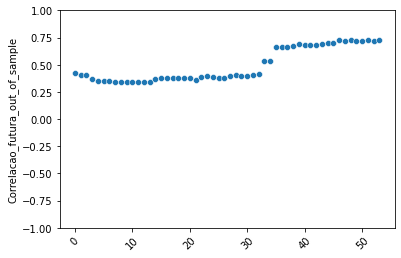

In [73]:
g =sns.scatterplot(range(0,len(df_sub.Ano)-(25+janela_target)),df_teste.Correlacao_futura_out_of_sample)
plt.xticks(rotation=45)
g.set(ylim=(-1, 1))
np.mean(df_teste.Correlacao_futura_out_of_sample)


c:\users\carol\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.6105429392996641

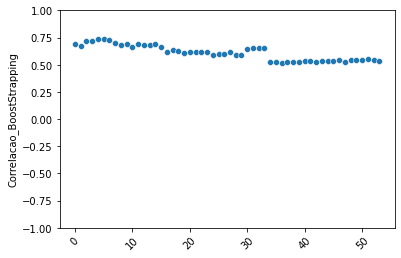

In [96]:
g =sns.scatterplot(range(0,len(df_sub.Ano)-(25+janela_target)),df_teste.Correlacao_BoostStrapping)
plt.xticks(rotation=45)
g.set(ylim=(-1, 1))
np.mean(df_teste.Correlacao_BoostStrapping)

c:\users\carol\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.6105429392996641

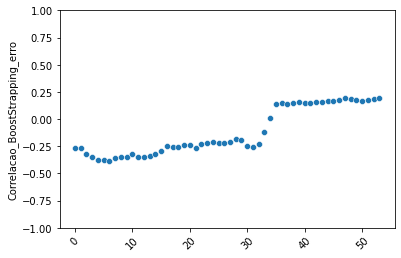

In [98]:
g =sns.scatterplot(range(0,len(df_sub.Ano)-(25+janela_target)),df_teste.Correlacao_BoostStrapping_erro)
plt.xticks(rotation=45)
g.set(ylim=(-1, 1))
np.mean(df_teste.Correlacao_BoostStrapping)

c:\users\carol\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.5105546100000802

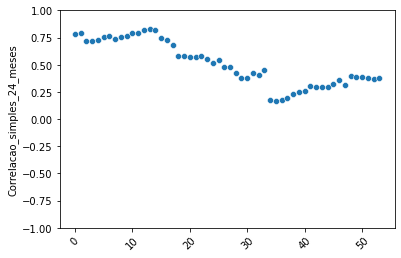

In [76]:
g =sns.scatterplot(range(0,len(df_sub.Ano)-(25+janela_target)),df_teste.Correlacao_simples_24_meses)
plt.xticks(rotation=45)
g.set(ylim=(-1, 1))
np.mean(df_teste.Correlacao_simples_24_meses)


c:\users\carol\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.6105429392996641

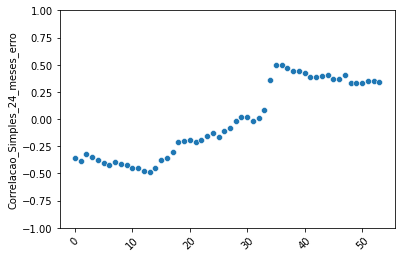

In [100]:
g =sns.scatterplot(range(0,len(df_sub.Ano)-(25+janela_target)),df_teste.Correlacao_Simples_24_meses_erro)
plt.xticks(rotation=45)
g.set(ylim=(-1, 1))
np.mean(df_teste.Correlacao_BoostStrapping)

0.5358093218563997 0.14251016047970116 (0.47191180874772576, 0.7491740698516024)


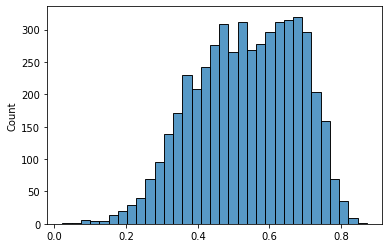

In [93]:

x= [func(df_sub,len(df_teste.Correlacao_BoostStrapping)) for i in range(5000)]
sns.histplot(x)
print(np.mean(x),np.std(x),confidence_interval)

confidence_interval = scipy.stats.t.interval(0.95, 4999, np.mean(x), np.std(x))


plt.savefig('distribuicao.png')